#### Dependencies

In [1]:
# !pip install numpy num2words nltk pandas Observations gensim
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# !pip install -U textblob
# !python -m textblob.download_corpora

#### Imports

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from num2words import num2words
from collections import Counter
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.special import gammaln
from collections import Counter
from textblob import TextBlob
from sklearn.manifold import TSNE
from pylab import savefig
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import pickle
import lda2
import scipy
import operator
import nltk
import os
import string
import copy
import pickle

### Preprocessing Methods

In [3]:
def convert_numbers(k):
    for i in range(len(k)):
        try:
            num2words(int(k[i]))
            k[i] = " "
        except:
            pass
    return k

def get_cosine(a, b):
    return 1 - spatial.distance.cosine(a, b)

def preprocess(pd):
    pd = pd.str.lower()
    pd = pd.str.replace('[{}]'.format('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\t'), ' ')
    pd = pd.apply(lambda x: [w for w in w_tokenizer.tokenize(x)])
    pd = pd.apply(lambda x: convert_numbers(x))
    pd = pd.str.join(' ')
    
    pd = pd.apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])    
    pd = pd.apply(lambda x: [item for item in x if item not in stop_words])
    return pd

def processReviews(reviews, window=5, MAX_VOCAB_SIZE=1000):
    vectorizer = CountVectorizer(analyzer="word",tokenizer=None)
    count_matrix = vectorizer.fit_transform(reviews)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    vocabulary = dict(zip(words,np.arange(len(words))))
    inv_vocabulary = dict(zip(np.arange(len(words)),words))
    return count_matrix.toarray(), tfidf_matrix.toarray(), vocabulary, words

### Score Methods

In [4]:
def coherence_score(X, topic_sentiment_df):
    X[X>1] = 1    
    totalcnt = len(topic_sentiment_df)
    total = 0
    for allwords in topic_sentiment_df:
        for word1 in allwords:
            for word2 in allwords:
                if word1 != word2:
                    ind1 = vocabulary[word1]
                    ind2 = vocabulary[word2]
                    total += np.log((np.matmul(X[:,ind1].T, X[:,ind2]) + 1.0)/np.sum(X[:,ind2]))
    return total/(2*totalcnt)

def kl_score(pk,qk):
    return (scipy.stats.entropy(pk,qk)*.5 + scipy.stats.entropy(qk,pk)*.5)

def get_hscore(dt_distribution, X, k):
    testlen = X.shape[0]
    all_kl_scores = np.zeros((testlen, testlen))
    for i in range(testlen-1):
        for j in range(i+1,testlen):
            score = kl_score(dt_distribution[i],dt_distribution[j])
            all_kl_scores[i,j] = score
            all_kl_scores[j,i] = score

    dt = np.zeros((X.shape[0], k))

    for i in range(X.shape[0]):
        dt[i, dt_distribution[i].argmax()]=1

    intradist = 0
    for i in range(k):
        cnt = dt[:,i].sum()
        tmp = np.outer(dt[:,i],dt[:,i])
        tmp = tmp * all_kl_scores
        intradist += tmp.sum()*1.0/(cnt*(cnt-1))
    intradist = intradist/k
    

    interdist = 0
    for i in range(k):
       for j in range(k):
           if i != j:
             cnt_i = dt[:,i].sum()
             cnt_j = dt[:,j].sum()
             tmp = np.outer(dt[:,i], dt[:,j])
             tmp = tmp * all_kl_scores
             interdist += tmp.sum()*1.0/(cnt_i*cnt_j)
    interdist = interdist/(k*(k-1))
    return intradist/interdist

### Required Methods

In [140]:
def plot_simple_TSNE(data, title):
    X_embedded = TSNE(n_components=2).fit_transform(data)

    X = np.array([i[0] for i in X_embedded])
    Y = np.array([i[1] for i in X_embedded])
    plt.scatter(X, Y)

    plt.title(title)
    plt.legend(loc=(1.04,0))
    plt.show()

def plot_TSNE(dt_distribution, C, labels, printit, title):
    X_embedded = TSNE(n_components=2).fit_transform(dt_distribution)
    plt.figure(figsize=(10, 10))
    X = np.array([i[0] for i in X_embedded])
    Y = np.array([i[1] for i in X_embedded])
    for i in range(len(labels)):
        xx = X[[np.where(C == i)[0].tolist()]]
        yy = Y[[np.where(C == i)[0].tolist()]]
        plt.scatter(xx, yy, label=labels[i])

    if printit:
        for idx, p in enumerate(X_embedded):
            plt.annotate(idx, (p[0], p[1]))
    plt.title(title)
    plt.legend(loc=(1.04,0))
    plt.show()
    
def get_doc_details(num):
    print("label: ", C[num])
    print(dataset[9][num])

#### Get unique words from medical words

In [6]:
# icd_words = pickle.load(open("unique_words.pickle",'rb'))
# stop_words = stopwords.words('english')
# lemmatizer = nltk.stem.WordNetLemmatizer()
# stemmer = nltk.stem.PorterStemmer()
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# with open("icd10_desc.txt") as f:
#     icd = f.readlines()
# icd = pd.DataFrame(icd)
# icd.shape
# icd[1] = preprocess(icd[0])
# unique_words = set()
# for i in icd[1].values:
#     unique_words = set(i) | unique_words
# len(unique_words)
# with open("unique_words.pickle", "wb") as p:
#     pickle.dump(unique_words, p)

### Read Data

In [7]:
dataset = pd.read_pickle("dataset_cleaned_autocorrected")

In [8]:
icd_words = pd.read_csv("strict_medical_words.txt", header=None)[0].values.tolist()

In [9]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

/root/miniconda3/envs/python2/lib/python2.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Prepare Data

In [10]:
dataset[8] = dataset[7].apply(lambda x: [item for item in x.split(" ") if item in icd_words])
dataset[9] = dataset[8].apply(lambda x: " ".join(x))

In [11]:
count_matrix, tfidf_matrix, vocabulary, words = processReviews(dataset[9].values)

In [12]:
count_matrix.shape, tfidf_matrix.shape

((100, 358), (100, 358))

### Find Edges

In [13]:
edges_threshold = 0.7

In [14]:
docs_edges, ignored, taken, count = [], [], [], 0
for idx, doc in enumerate(dataset[8].values):
    edges = []
    for i in doc:
        for j in doc:
            if i != j:
                try:
                    a = embeddings_index[i]
                    b = embeddings_index[j]
                    if get_cosine(a, b) > edges_threshold:
                        edges.append((vocabulary[i], vocabulary[j]))
                except:
                    try:
                        embeddings_index[i]
                        taken.append(i)
                    except:
                        ignored.append(i)
                    try:
                        embeddings_index[j]
                    except:
                        ignored.append(j)
                        taken.append(j)
                    pass
    docs_edges.append(edges)

In [15]:
edge_dict = {}
for i in docs_edges:
    for j in i:
        try:
            edge_dict[j[0]] += [j[1]]
        except:
            edge_dict[j[0]] = [j[1]]

## Run Model

In [106]:
k = N_TOPICS = 9
lambda_param = 1.0

In [107]:
sampler = lda2.LdaSampler(n_topics=N_TOPICS, lambda_param=lambda_param)

In [108]:
for it, phi in enumerate(sampler.run(count_matrix, edge_dict, maxiter=100)):
    sampler.loglikelihood(docs_edges)

In [109]:
t_words = sampler.getTopKWords(5, words)
top_words = [t_words[i] for i in t_words.keys()]
document_topic = sampler.theta().argmax(axis=1)

### Evaluation

In [110]:
coherence_score(count_matrix, top_words)

-7.393434089426474

In [111]:
get_hscore(sampler.theta(), count_matrix, k)

0.18641568501536063

In [112]:
topics_generated = sampler.theta().argmax(axis=1)
document_word_sampler = np.dot(sampler.theta(), sampler.phi())

In [113]:
top_words

[[u'cell', u'hiv', u'ecg', u'skin', u'urine'],
 [u'genetic', u'anesthetic', u'institution', u'respiratory', u'sepsis'],
 [u'limb', u'oral', u'decreased', u'fistula', u'multiple'],
 [u'murmur', u'node', u'cyanosis', u'cancer', u'carcinoma'],
 [u'hip', u'joint', u'restricted', u'due', u'knee'],
 [u'hiv', u'ecg', u'potassium', u'lymphocyte', u'urea'],
 [u'stone', u'symptomatic', u'oriented', u'urology', u'surgical'],
 [u'allergy', u'diabetic', u'consciousness', u'cycle', u'chemotherapy'],
 [u'residual', u'angioplasty', u'using', u'proximal', u'artery']]

### Visualizing D-T

In [115]:
N_TOPICS = 9

In [116]:
# labels = ['Kidney', 'HIV', 'Blood', 'Stunt', 'Weak', 'Diagnosis', 'Sinus', 'Cancer', 'Abdomen']
labels = list(xrange(N_TOPICS))
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8]

/root/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/root/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



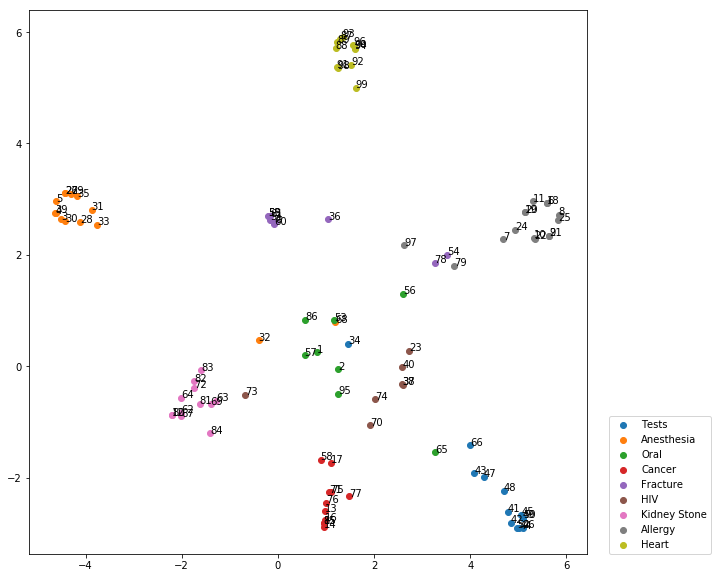

In [141]:
plot_TSNE(document_word_sampler, topics_generated, labels, True, "")

### Required Funcitons

In [118]:
def sample_data(data, topics, topic_selected):
    sampled, idxx = [], []
    for idx, i in enumerate(topics):
        if i == topic_selected:
            sampled.append(data[idx].tolist())
            idxx.append(idx)
    return np.array(sampled), idxx

In [119]:
def get_mahalanobis(matrix):
    return (np.dot(np.dot(np.array(matrix - np.mean(matrix, axis=0)), 
                         np.linalg.inv(np.cov(matrix.T))), np.array(matrix - np.mean(matrix, axis=0)).T)).diagonal()

# getting outlyers

In [120]:
reduced_dim = TSNE(n_components=2).fit_transform(document_word_sampler)

In [121]:
sampled_all, idxx_all, mahalanobis_all = [], [], []
for topic in range(N_TOPICS):
    sampled, idxx = sample_data(reduced_dim, topics_generated, topic)
    sampled_all.append(sampled)
    idxx_all.append(idxx)
    mahalanobis_all.append(get_mahalanobis(sampled))

# Threshold

In [122]:
from scipy.stats import chi2

In [123]:
t = chi2.ppf(0.90, 2)

In [124]:
for l, (m, idxxs) in enumerate(zip(mahalanobis_all, idxx_all)):
    print(l, np.where(m>t)[0].tolist(), [idxxs[i] for i in np.where(m>t)[0].tolist()])

(0, [0], [34])
(1, [9, 13], [32, 68])
(2, [3, 5], [56, 65])
(3, [5, 9], [58, 77])
(4, [1], [36])
(5, [5], [73])
(6, [11], [84])
(7, [14], [97])
(8, [10], [99])


In [139]:
dataset[9][37]

u'preterm respiratory sepsis sodium potassium hemoglobin bilirubin glucose urea neutrophil lymphocyte absolute neutrophil platelet cell unit'

In [ ]:
rani - 3, carewell - 2, chirayu - 2, gaba, v car, rama, aiims, dhanwantari

In [126]:
import plotly

In [127]:
import plotly.plotly as py
import plotly.graph_objs as go

In [128]:
py.sign_in("william18026", "wC9Ph9QUtlZr4las0C2p")

In [130]:
len(labels)

9

In [133]:
traces = []
labels = ['Tests', 'Anesthesia', 'Oral', 'Cancer', "Fracture", 'HIV', 'Kidney Stone', 'Allergy', 'Heart']
for i in range(N_TOPICS):
    X = []
    Y = []
    idds = []
    for idx, j in enumerate(topics_generated):
        if j == i:
            X.append(reduced_dim[idx][0])
            Y.append(reduced_dim[idx][1])
            idds.append("Chart: "+str(idx+1))
    trace = go.Scatter(
        x = X,
        y = Y,
        text = idds,
        mode = 'markers',
        name = labels[i],
        marker = dict(
            line = dict(width = 1)
        )
    )
    traces.append(trace)

In [134]:
py.iplot(traces, filename='basic-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~william18026/0 or inside your plot.ly account where it is named 'basic-scatter'
